In [61]:
import os
import sys
from os.path import join
import json

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nfl_data_py as nfl

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(ROOT_DIR,'py'))

import util

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

with open("paths.json", 'r') as f:
    paths = json.load(f)

PROCESSED_DATA_PATH = paths['processed_data']

In [62]:
WEEK = 1

df_tracking = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{WEEK}', 'tracking.pkl'))
df_game = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{WEEK}', 'games.pkl'))
df_play = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{WEEK}', 'play.pkl'))
df_player_play = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{WEEK}', 'player_play.pkl'))
df_player = pd.read_pickle(join(PROCESSED_DATA_PATH, 'players.pkl'))
df_team = pd.read_pickle(join(PROCESSED_DATA_PATH, 'teams.pkl'))

In [63]:
df_tracking['position'] = np.where(
    df_tracking.display_name == "Taysom Hill",
    "TE",
    df_tracking.position
)

In [64]:
# make sure there are no 2 qb plays
df_tracking.query('position=="QB" and frame_type=="SNAP"')[['game_play_id','club']].value_counts().head(10)

game_play_id     club
2022090800_1009  BUF     1
2022091106_1919  NE      1
2022091109_1499  JAX     1
2022091109_1636  WAS     1
2022091109_1729  WAS     1
2022091109_187   JAX     1
2022091109_2383  JAX     1
2022091109_2404  JAX     1
2022091109_2481  JAX     1
2022091109_2558  WAS     1
dtype: int64

In [65]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_play(
    df_tracking, 
    game_play_id, 
    every_other_frame=True, 
    event_col='event',
    highlight_lineman=False,
    highlight_qb=False
) -> HTML:
    qry = 'game_play_id==@game_play_id'
    tracking_play = df_tracking.query(qry).copy().reset_index(drop=True)

    # Kepe every other frame, the first and last frames, and frames with events
    first_frame = tracking_play['frame_id'].min()
    last_frame = tracking_play['frame_id'].max()
    frames_with_events = tracking_play.groupby('frame_id')[event_col].transform('any')

    if every_other_frame:
        tracking_play = tracking_play[
            (tracking_play['frame_id'] == first_frame) | 
            (tracking_play['frame_id'] == last_frame) | 
            (frames_with_events) |
            (tracking_play['frame_id'] % 2 == 0)  # Keep even frames only
        ].copy().reset_index(drop=True)

    frames = tracking_play['frame_id'].unique()
    current_event = [None]  

    field_width = 53.3

    fig, ax = plt.subplots(figsize=(10, 5))

    padding = 2
    min_y = tracking_play.y.min() - padding
    max_y = tracking_play.y.max() + padding

    los = tracking_play['absolute_yardline_number'].iloc[0]
    to_go_line = los + tracking_play['yards_to_go'].iloc[0]

    def update(frame_id):
        """Update function for each animation frame."""
        ax.clear()

        # can you make the field a light grey color?
        ax.set_facecolor('lightgrey')
        
        ax.set_yticks(np.arange(10, 110+1, 5))
        ax.grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='black', zorder=1)

        for spine in ax.spines.values():
            spine.set_visible(False)

        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        ax.set_xlim(0, field_width)
        ax.set_ylim(min_y, max_y)

        current_frame = tracking_play.query('frame_id == @frame_id')
        if highlight_lineman and highlight_qb:
            offense = current_frame.query('offense and position not in ["QB","T","G","C"]')
            lineman = current_frame.query('offense and position in ["T","G","C"]')
            qb = current_frame.query('offense and position == "QB"')
        elif highlight_lineman:
            offense = current_frame.query('offense and position not in ["T","G","C"]')
            lineman = current_frame.query('offense and position in ["T","G","C"]')
        elif highlight_qb:
            offense = current_frame.query('offense and position != "QB"')
            qb = current_frame.query('offense and position == "QB"')
        else:
            offense = current_frame.query('offense')
        defense = current_frame.query('~offense and club != "football"')
        football = current_frame.query('club == "football"')

        # plot the los in blue
        ax.axhline(los, color='blue', linewidth=1.2, linestyle='-', zorder=1)

        # plot the line to go
        ax.axhline(to_go_line, color='yellow', linewidth=1.2, linestyle='-', zorder=1)

        # event = current_frame[event_col].iloc[0] if not current_frame[event_col].isna().all() else None
        # if event:
        #     current_event[0] = event

        ax.scatter(offense.x, offense.y, c='red', edgecolor='black', label='Offense', zorder=2)
        ax.scatter(defense.x, defense.y, c='blue', edgecolor='black', label='Defense', zorder=2)
        ax.scatter(football.x, football.y, c='brown', edgecolor='black', label='Football', s=20, zorder=3)

        if highlight_lineman:
            ax.scatter(lineman.x, lineman.y, c='green', edgecolor='black', label='Lineman', zorder=2)
        if highlight_qb:
            ax.scatter(qb.x, qb.y, c='purple', edgecolor='black', label='QB', zorder=2)

        event = current_frame[event_col].iloc[0]
        box_color = 'white'  # Default color
        alpha_value = 0.8    # Transparency value
        
        # Set box color based on event type
        if event == 'line_set':
            box_color = 'green'
            alpha_value = 0.5  # More transparency for the green box
        elif event == 'ball_snap':
            box_color = 'red'
            alpha_value = 0.5  # More transparency for the red box
        
        ax.text(
            1, max_y + 1.5, f"{event}",
            fontsize=12, ha='left', color='black',
            bbox=dict(facecolor=box_color, alpha=alpha_value),
            zorder=4
        )

        ax.text(52.3, max_y + 1.5, f"{frame_id / 10:.01f} s", fontsize=12, ha='right', color='black', 
                bbox=dict(facecolor='white', alpha=0.8), zorder=4)

    ani = FuncAnimation(fig, update, frames=frames, interval=100, repeat=False)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=.9)

    plt.close(fig)

    return HTML(ani.to_jshtml(fps=5))

In [66]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

tqdm.pandas()

def add_line_set_event(
    df_tracking: pd.DataFrame,
    events_col: str = 'event_new'
) -> pd.DataFrame:

    WINDOW_WIDTH = 3
    LINE_SET_MEAN_SPEED_THRESHOLD = 0.3
    SPEED_MULTIPLIER_THRESHOLD = 2.0
    SPEED_MULTIPLIER = 3
    MIN_AREA_PCT_ABOVE_THRESH = .01
    
    def set_lineset_frame_id(play: pd.DataFrame) -> pd.DataFrame:    
        off_players = play[(play.offense) & (play.frame_type == 'BEFORE_SNAP')].copy()

        off_players['s'] = np.where(
            off_players['s'] >= SPEED_MULTIPLIER_THRESHOLD, 
            off_players['s'] * SPEED_MULTIPLIER, 
            off_players['s']
        )
        off_team = off_players[['frame_id', 's']].groupby('frame_id')['s'].mean().reset_index(drop=True)
        
        off_team_smoothed = off_team.rolling(window=WINDOW_WIDTH, min_periods=1, center=True).mean()

        differences = off_team_smoothed - LINE_SET_MEAN_SPEED_THRESHOLD
        df = pd.DataFrame(
            differences, 
            columns=['s'], 
            index=(off_players.frame_id.unique())
        ).rename({'s':'diff_with_speed_thresh'},axis=1)

        # Group by frames by the area groups above and below the thresholds
        df['above_thresh'] = np.where(df.diff_with_speed_thresh > 0, True, False)
        df['prev_above_thresh'] = df.above_thresh.shift(1).fillna(False)
        df['new_group'] = ((df.above_thresh & ~df.prev_above_thresh) | (~df.above_thresh & df.prev_above_thresh))
        df['group'] = df.new_group.cumsum()
        df.drop(['prev_above_thresh','new_group'],axis=1, inplace=True)
        df['area'] = df.groupby('group')['diff_with_speed_thresh'].transform('sum')
        tot_area = df.drop_duplicates('group')['area'].abs().sum()
        df['area_pct'] = df['area'].abs() / tot_area
        df['diff_with_speed_thresh'] = np.where(
            (df.area_pct < MIN_AREA_PCT_ABOVE_THRESH) & df.above_thresh,
            -1e-10, # set to very small negative so these points aren't selected as lineset 
            df.diff_with_speed_thresh
        )

        # If ah area above the thresh is too small (minor player movements), join it with area below the thresh (line_set)
        df['above_thresh'] = np.where(df.diff_with_speed_thresh > 0, True, False)
        df['prev_above_thresh'] = df.above_thresh.shift(1).fillna(False)
        df['new_group'] = ((df.above_thresh & ~df.prev_above_thresh) | (~df.above_thresh & df.prev_above_thresh))
        df['group'] = df.new_group.cumsum()
        df.drop(['prev_above_thresh','new_group'],axis=1, inplace=True)
        df['area'] = df.groupby('group')['diff_with_speed_thresh'].transform('sum')
        df['diff_with_speed_thresh'] = df['diff_with_speed_thresh'] * (df.index/1e3 + 1)
        line_set_frame_ids = df[~df.above_thresh].groupby('group').diff_with_speed_thresh.idxmin().values.tolist()
        line_set_frame_ids = [v for v in line_set_frame_ids if v == v] # remove np.nan values

        if line_set_frame_ids:
            play.loc[play[play['frame_id'].isin(line_set_frame_ids)].index, events_col] = 'line_set'
        else:
            frame_before_snap = play[play['frame_type']=="SNAP"].frame_id.iloc[0] - 1
            play.loc[play['frame_id'] == frame_before_snap, events_col] = 'line_set'
            gpid = play.game_play_id.iloc[0]
            print(f'WARNING: defaulted {gpid}\'s line_set value to one frame before ball snap.')
        
        return play

    return df_tracking.groupby('game_play_id', group_keys=False).progress_apply(set_lineset_frame_id)
    
def create_events(
    df_tracking: pd.DataFrame, 
    events_col: str = 'event_new'
) -> pd.DataFrame:
    '''Create events for line set and ball snap.

    Args:
        df_tracking: Tracking data
        events_col: Column name for the events
    Returns:
        DataFrame with the new events column
    '''

    if events_col in df_tracking.columns:
        df_tracking.drop(columns=events_col, inplace=True)
    
    df_tracking[events_col] = np.nan

    df_tracking = add_line_set_event(df_tracking, events_col=events_col)

    # Add 'ball_snap' event
    df_tracking.loc[df_tracking['frame_type'] == 'SNAP', events_col] = 'ball_snap'

    return df_tracking

In [67]:
df_tracking = create_events(df_tracking)

  0%|          | 0/641 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Drop plays with fewer than 5 offensive line players

offensive_line = ['T','G','C']

# list plays with fewer than 5 offensive line players
o_line = df_tracking[
    df_tracking['position'].isin(offensive_line) &
   (df_tracking.frame_type == "SNAP")
]
o_line = o_line.groupby('game_play_id').size().reset_index(name='count')
o_line = o_line[o_line['count'] < 5]
drop_gid = o_line.game_play_id.unique().tolist()

if len(drop_gid) == 0:
    print("No plays with fewer than 5 offensive line players")
else:
    print(f"Dropping {len(drop_gid)} plays with fewer than 5 offensive line players")
    df_tracking = df_tracking[~df_tracking.game_play_id.isin(drop_gid)]
    df_play = df_play[~df_play.game_play_id.isin(drop_gid)]
    df_player_play = df_player_play[~df_player_play.game_play_id.isin(drop_gid)]
    df_game = df_game[~df_game.game_id.isin(df_play.game_id.unique())]

No plays with fewer than 5 offensive line players


In [32]:
# Drop offensive_formation == WILDCAT plays
wildcat_plays = df_play[
    df_play['offense_formation'] == "WILDCAT"
].game_play_id.unique()

if len(wildcat_plays) == 0:
    print("No WILDCAT plays to drop")
else:
    print(f"Dropping {len(wildcat_plays)} WILDCAT plays")
    df_tracking = df_tracking[~df_tracking.game_play_id.isin(wildcat_plays)]
    df_play = df_play[~df_play.game_play_id.isin(wildcat_plays)]
    df_player_play = df_player_play[~df_player_play.game_play_id.isin(wildcat_plays)]
    df_game = df_game[~df_game.game_id.isin(df_play.game_id.unique())]

Dropping 2 WILDCAT plays


In [44]:
# Find the offensive lineman with the smallest dx from the qb at the last event_new=="line_set"

MOVEMENT_THRESHOLD = 1

cols = ['game_play_id','frame_id','frame_type','position','display_name','x','y','event_new']
lineman_and_qb = df_tracking[
    (df_tracking.frame_type == 'BEFORE_SNAP') & 
    df_tracking.offense & 
    df_tracking.position.isin(offensive_line + ['QB'])
][cols]

last_line_set_event = (
    df_tracking[df_tracking.event_new == 'line_set']
    .groupby('game_play_id')
    .frame_id.max()
    .reset_index()
    .rename(columns={'frame_id': 'line_set_fid'})
)
lineman_and_qb = (
    lineman_and_qb
    .merge(last_line_set_event, on='game_play_id')
    .query('frame_id == line_set_fid')
)

lineman_and_qb['farthest_forward_lineman'] = (
    lineman_and_qb
    .query('position != "QB"')
    .groupby('game_play_id')
    .y.transform('max')
)
lineman_and_qb['farthest_forward_lineman'] = np.where(
    lineman_and_qb.farthest_forward_lineman == lineman_and_qb.y,
    True,
    False
)
x_qb = (
    lineman_and_qb
    .query('position == "QB"')
    [['game_play_id','x']]
    .rename(columns={'x': 'x_qb'})
)
lineman_and_qb = lineman_and_qb.merge(x_qb, on='game_play_id')
lineman_and_qb['dx'] = np.abs(lineman_and_qb.x - lineman_and_qb.x_qb)
lineman_and_qb['closest_to_qb'] = (
    lineman_and_qb
    .query('position != "QB"')
    .groupby('game_play_id')
    .dx.transform('min')
)
lineman_and_qb['closest_to_qb'] = np.where(
    lineman_and_qb.closest_to_qb == lineman_and_qb.dx,
    True,
    False
)
lineman_and_qb['is_center'] = np.where(
    lineman_and_qb.closest_to_qb & lineman_and_qb.farthest_forward_lineman,
    True,
    False
)

In [45]:
# find plays with no is_center True
lineman_and_qb.groupby('game_play_id').is_center.sum().reset_index().query('is_center != 1')

game_play_id  is_center
38   2022091100_2114          0
43   2022091100_2512          0
59    2022091100_546          0
60    2022091100_594          0
62    2022091100_762          0
81   2022091101_2386          0
91    2022091101_296          0
96   2022091101_3287          0
98   2022091101_3336          0
99   2022091101_3357          0
285  2022091105_3413          0

In [ ]:
gpid = '2022091105_3413'
lineman_and_qb.query('game_play_id==@gpid')

game_play_id  frame_id   frame_type position    display_name      x  \
2222  2022091105_3413       113  BEFORE_SNAP       QB       Matt Ryan  29.44   
2223  2022091105_3413       113  BEFORE_SNAP        C      Ryan Kelly  29.37   
2224  2022091105_3413       113  BEFORE_SNAP        G  Quenton Nelson  27.83   
2225  2022091105_3413       113  BEFORE_SNAP        T    Braden Smith  32.28   
2226  2022091105_3413       113  BEFORE_SNAP        T      Matt Pryor  26.19   
2227  2022091105_3413       113  BEFORE_SNAP        C    Danny Pinter  30.95   

           y event_new  line_set_fid  farthest_forward_lineman   x_qb    dx  \
2222  106.11  line_set           113                     False  29.44  0.00   
2223  106.91  line_set           113                     False  29.44  0.07   
2224  106.68  line_set           113                     False  29.44  1.61   
2225  107.02  line_set           113                      True  29.44  2.84   
2226  106.40  line_set           113                     False  29.44  3.25   
2227  106.70  line_set           113                     False  29.44  1.51   

      closest_to_qb  is_center  
2222          False      False  
2223           True      False  
2224          False      False  
2225          False      False  
2226          False      False  
2227          False      False

In [ ]:
plot_play(df_tracking, gpid, event_col='event_new', highlight_lineman=True, highlight_qb=True)

KeyboardInterrupt: 

In [51]:
df_play.query('game_play_id==@gpid').play_description.iloc[0]

'(13:10) (Shotgun) T.Hill right tackle to ATL 49 for 9 yards (R.Grant).'

In [31]:
df_play.offense_formation.value_counts()

SINGLEBACK    271
SHOTGUN       240
I_FORM         88
PISTOL         34
JUMBO           5
WILDCAT         2
EMPTY           1
Name: offense_formation, dtype: int64

In [22]:
df_player.position.value_counts()

WR     224
CB     189
OLB    135
DE     131
RB     126
TE     123
DT     121
T      117
G      107
ILB     93
FS      79
SS      65
QB      62
C       61
NT      32
MLB     16
FB      14
DB       1
LB       1
Name: position, dtype: int64

In [6]:
import numpy as np
import pandas as pd

MOVEMENT_THRESHOLD = 1

ball_tracking = df_tracking[(df_tracking.club == 'football') & (df_tracking.frame_type == 'BEFORE_SNAP')]

snap_frames = df_tracking[df_tracking.frame_type == 'SNAP'][['game_play_id', 'frame_id']].rename(columns={'frame_id': 'ball_snap_fid'})
ball_tracking = ball_tracking.merge(snap_frames, on='game_play_id')

last_line_set_event = (
    df_tracking[df_tracking.event_new == 'line_set']
    .groupby('game_play_id')
    .frame_id.max()
    .reset_index()
    .rename(columns={'frame_id': 'line_set_fid'})
)
ball_tracking = ball_tracking.merge(last_line_set_event, on='game_play_id')

# Filter frames up to 3 frames before the ball_snap_fid
ball_tracking = ball_tracking[
    (ball_tracking['frame_id'] <= (ball_tracking['ball_snap_fid'] - 2)) &
    (ball_tracking['frame_id'] >= ball_tracking['line_set_fid'])
]

# Calculate max and min for x and y for each game_play_id
ball_movement = ball_tracking.groupby('game_play_id').agg({'x': ['min', 'max'], 'y': ['min', 'max']}).reset_index()
ball_movement.columns = ['game_play_id', 'x_min', 'x_max', 'y_min', 'y_max']

# Calculate total movement and filter out excessive movements
ball_movement['delta_x'] = (ball_movement['x_max'] - ball_movement['x_min'])
ball_movement['delta_y'] = (ball_movement['y_max'] - ball_movement['y_min'])
ball_movement['total_movement'] = np.sqrt(ball_movement['delta_x']**2 + ball_movement['delta_y']**2)
drop_gids = ball_movement[
    (ball_movement['total_movement'] >= MOVEMENT_THRESHOLD)
].game_play_id.tolist()

print(drop_gids)

['2022091102_3943', '2022091108_1089', '2022091108_2724', '2022091109_1636', '2022091109_3116', '2022091109_3463']


In [7]:
len(drop_gids)

6

In [8]:
ball_movement.query('total_movement >= .5').sort_values('total_movement', ascending=False).reset_index(drop=True)

game_play_id      x_min      x_max       y_min       y_max   delta_x  \
0   2022091109_1636  29.830000  29.980000    8.250000   10.269997  0.150000   
1   2022091108_1089  23.810000  24.640000   67.029999   67.989998  0.830000   
2   2022091109_3463  23.310000  23.380000   97.720001   98.970001  0.070000   
3   2022091108_2724  26.099999  26.150000   14.250000   15.360000  0.050001   
4   2022091109_3116  29.310000  29.320000   39.500000   40.570000  0.010000   
5   2022091102_3943  23.780001  23.850000   60.700001   61.709999  0.070000   
6    2022091110_994  23.930000  23.950001  106.940000  107.850000  0.020000   
7   2022091104_2269  29.719999  29.840000  105.510000  106.410000  0.120001   
8   2022091101_3125  23.609999  23.660001   93.889999   94.769997  0.050001   
9   2022091101_3357  29.490000  29.709999   86.520000   87.290001  0.219999   
10  2022091112_3530  29.390000  29.970000   52.230000   52.750000  0.580000   
11  2022091104_2807  23.590001  23.650000   50.349998   51.029999  0.059999   
12   2022091101_417  23.450000  23.480000   38.450001   39.130001  0.030001   
13   2022091106_466  23.799999  23.910000   87.169998   87.799999  0.110001   
14  2022091110_3471  23.930000  24.030001   89.490000   90.110001  0.100000   
15   2022091110_729  23.349999  23.450000   34.830002   35.330002  0.100000   

     delta_y  total_movement  
0   2.019997        2.025558  
1   0.959999        1.269054  
2   1.250000        1.251958  
3   1.110000        1.111125  
4   1.070000        1.070046  
5   1.009998        1.012421  
6   0.910001        0.910221  
7   0.900000        0.907964  
8   0.879997        0.881417  
9   0.770000        0.800812  
10  0.520000        0.778974  
11  0.680000        0.682642  
12  0.680000        0.680662  
13  0.630001        0.639532  
14  0.620001        0.628014  
15  0.500000        0.509902

In [20]:
gpid = '2022091109_3463'
plot_play(df_tracking, gpid, event_col='event_new')

In [33]:
# Check that there is a line_set event for each play
line_set_check = df_tracking[df_tracking['event_new'] == 'line_set'].game_play_id.nunique() == df_play.game_play_id.nunique()
ball_snap_check = df_tracking[df_tracking['event_new'] == 'ball_snap'].game_play_id.nunique() == df_play.game_play_id.nunique()

print(f'There is a line_set event for each play: {line_set_check}')
print(f'There is a ball_snap event for each play: {ball_snap_check}')

There is a line_set event for each play: True
There is a ball_snap event for each play: True


In [34]:
SPEED_THRESHOLD = 1.0
MOTION_THRESHOLD = 4
X_LAST_FRAMES_MOVING = 2

df_motion = df_tracking.copy()
df_snap_frames = df_motion[df_motion['frame_type'] == 'SNAP'].groupby('game_play_id')['frame_id'].first().reset_index()
df_motion = df_motion.merge(df_snap_frames, on='game_play_id', suffixes=('', '_ball_snap'))
del df_snap_frames
df_motion = df_motion[
    (df_motion['frame_id_ball_snap'] - 10 <= df_motion['frame_id'] ) &
    (df_motion['frame_id'] <= df_motion['frame_id_ball_snap']) &
    df_motion.offense
]
df_motion['frame_weight'] = np.where(
    df_motion['frame_id'] == df_motion['frame_id_ball_snap'],
    10,
    (df_motion['frame_id'] - df_motion['frame_id_ball_snap']) % 10
)

# groupby game_play_id and nfl_id. count the number of times their s is avoe SPEED_THRESHOLD
df_motion['moving'] = df_motion['s'] >= SPEED_THRESHOLD
df_motion['weighted_moving'] = df_motion['s'] * (1 + (df_motion['frame_weight'] * 0.1)) >= SPEED_THRESHOLD
df_motion['moving_and_last_X_frames'] = np.where(
    (df_motion['frame_weight'] > 10 - X_LAST_FRAMES_MOVING) & df_motion['moving'],
    True,
    False
)
df_player_in_motion = (
    df_motion.groupby(['game_play_id', 'nfl_id'])
    .agg(
        num_frames_moving=('moving', 'sum'), 
        num_frames_moving_weighted=('weighted_moving', 'sum'),
        num_frames_moving_and_last_X_frames=('moving_and_last_X_frames', 'sum'),
        avg_speed=('s', 'mean')
    ).reset_index()
)
df_player_in_motion['in_motion'] = np.where(
    (df_player_in_motion['num_frames_moving'] >= MOTION_THRESHOLD) |
    (df_player_in_motion['num_frames_moving_weighted'] >= MOTION_THRESHOLD) |
    (df_player_in_motion['num_frames_moving_and_last_X_frames'] >= X_LAST_FRAMES_MOVING),
    True,
    False
)

# Filter by eligible positions
df_player_in_motion = df_player_in_motion.merge(df_player[['nfl_id', 'position','display_name']], on='nfl_id')
motion_eligaible_positions = ['WR', 'TE', 'RB', 'FB']
df_player_in_motion['in_motion'] = np.where(
    (
        df_player_in_motion.in_motion & 
        (
            df_player_in_motion.position.isin(motion_eligaible_positions) |
            (df_player_in_motion.display_name == 'Taysom Hill')
        )
    ),
    True, 
    False
)

In [254]:
df_player_in_motion.query('in_motion').sort_values('avg_speed', ascending=True).head(10)

game_play_id   nfl_id  num_frames_moving  num_frames_moving_weighted  \
59    2022090800_2072  47879.0                  2                           2   
64     2022090800_529  47879.0                  2                           3   
3687  2022091106_1945  44912.0                  3                           4   
4932  2022091109_3463  42302.0                  2                           3   
6002  2022091112_3551  43971.0                  3                           4   
58    2022090800_2043  47879.0                  3                           4   
1245  2022091101_2683  53512.0                  0                           5   
4990  2022091109_4075  44852.0                  3                           4   
1176  2022091101_2365  44841.0                  0                           6   
2488  2022091104_1115  53541.0                  2                           5   

      num_frames_moving_and_last_X_frames  avg_speed  in_motion position  \
59                                      2   0.318182       True       TE   
64                                      2   0.483636       True       TE   
3687                                    2   0.509091       True       TE   
4932                                    2   0.520000       True       TE   
6002                                    2   0.530000       True       FB   
58                                      2   0.579091       True       TE   
1245                                    0   0.606364       True       TE   
4990                                    0   0.644545       True       WR   
1176                                    0   0.650000       True       TE   
2488                                    0   0.656364       True       WR   

           display_name  
59          Dawson Knox  
64          Dawson Knox  
3687        Jonnu Smith  
4932     Chris Manhertz  
6002           C.J. Ham  
58          Dawson Knox  
1245      Tommy Tremble  
4990      Curtis Samuel  
1176        David Njoku  
2488  Amon-Ra St. Brown

In [36]:
df_player_in_motion.query('motion_player').shape[0] / df_play.game_play_id.nunique()

0.43525741029641185

In [35]:
df_player_in_motion = (
    df_player_in_motion.query('in_motion')
    .drop(columns=[
        'position','display_name','num_frames_moving','num_frames_moving_weighted',
        'num_frames_moving_and_last_X_frames','avg_speed'
    ]).rename(columns={'in_motion':'motion_player'})
)

if 'motion_player' in df_tracking.columns:
    df_tracking.drop(columns='motion_player', inplace=True)

df_tracking = df_tracking.merge(df_player_in_motion, on=['game_play_id', 'nfl_id'], how='left')
df_tracking['motion_player'] = df_tracking['motion_player'].fillna(False)

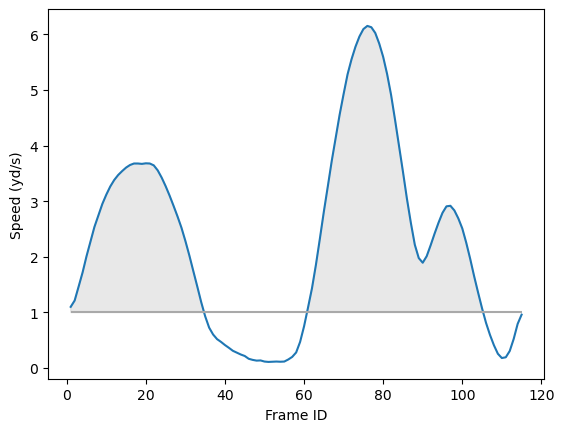

In [238]:
gpid = '2022091102_900'
NON_STATIONARY_THRESHOLD = 1.0
MOVING_WINDOW = 3

qry = (
    df_tracking.query(
        'game_play_id==@gpid & ' +\
        'offense & ' +\
        'frame_type.isin(["BEFORE_SNAP","SNAP"]) & ' +\
        'motion_player'
    )
)[['frame_id','s']]

qry['s_smoothed'] = qry['s'].rolling(window=MOVING_WINDOW, min_periods=1, center=True).mean()

plt.plot(qry.frame_id, qry.s_smoothed, zorder=2)
plt.hlines(NON_STATIONARY_THRESHOLD, xmin=qry.frame_id.min(), xmax=qry.frame_id.max(), color='darkgrey')
# shade area above threshold where player is moving
plt.fill_between(
    qry.frame_id,  # x values
    qry.s_smoothed,        # y values
    NON_STATIONARY_THRESHOLD,  # baseline
    where=qry.s_smoothed > NON_STATIONARY_THRESHOLD,  # condition for shading
    interpolate=True,         # interpolates between points
    color='lightgrey',       # shading color
    alpha=0.5,                 # transparency
    zorder=0
)
plt.xlabel('Frame ID')
plt.ylabel('Speed (yd/s)')

# highlinght the area in red of last 10 frames

plot_play(df_tracking, gpid, event_col='event_new')

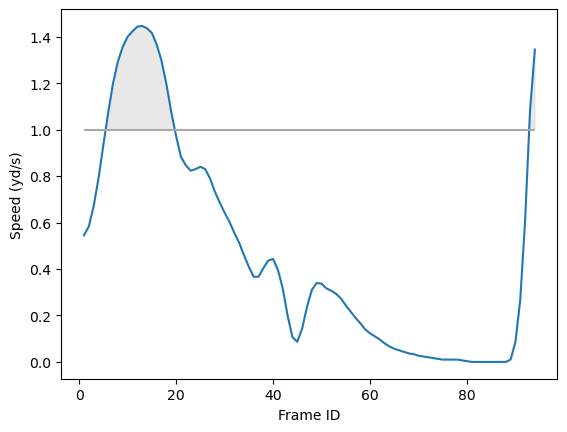

In [256]:
gpid = '2022090800_2072'
NON_STATIONARY_THRESHOLD = 1.0
MOVING_WINDOW = 3

qry = (
    df_tracking.query(
        'game_play_id==@gpid & ' +\
        'offense & ' +\
        'frame_type.isin(["BEFORE_SNAP","SNAP"]) & ' +\
        'motion_player'
    )
)[['frame_id','s']]

qry['s_smoothed'] = qry['s'].rolling(window=MOVING_WINDOW, min_periods=1, center=True).mean()

plt.plot(qry.frame_id, qry.s_smoothed, zorder=2)
plt.hlines(NON_STATIONARY_THRESHOLD, xmin=qry.frame_id.min(), xmax=qry.frame_id.max(), color='darkgrey')
# shade area above threshold where player is moving
plt.fill_between(
    qry.frame_id,  # x values
    qry.s_smoothed,        # y values
    NON_STATIONARY_THRESHOLD,  # baseline
    where=qry.s_smoothed > NON_STATIONARY_THRESHOLD,  # condition for shading
    interpolate=True,         # interpolates between points
    color='lightgrey',       # shading color
    alpha=0.5,                 # transparency
    zorder=0
)
plt.xlabel('Frame ID')
plt.ylabel('Speed (yd/s)')

plot_play(df_tracking, gpid, event_col='event_new')

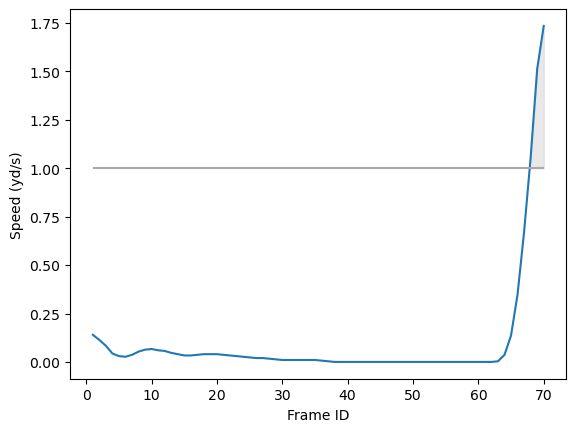

In [258]:
gpid = '2022091106_1945'
NON_STATIONARY_THRESHOLD = 1.0
MOVING_WINDOW = 3

qry = (
    df_tracking.query(
        'game_play_id==@gpid & ' +\
        'offense & ' +\
        'frame_type.isin(["BEFORE_SNAP","SNAP"]) & ' +\
        'motion_player'
    )
)[['frame_id','s']]

qry['s_smoothed'] = qry['s'].rolling(window=MOVING_WINDOW, min_periods=1, center=True).mean()

plt.plot(qry.frame_id, qry.s_smoothed, zorder=2)
plt.hlines(NON_STATIONARY_THRESHOLD, xmin=qry.frame_id.min(), xmax=qry.frame_id.max(), color='darkgrey')
# shade area above threshold where player is moving
plt.fill_between(
    qry.frame_id,  # x values
    qry.s_smoothed,        # y values
    NON_STATIONARY_THRESHOLD,  # baseline
    where=qry.s_smoothed > NON_STATIONARY_THRESHOLD,  # condition for shading
    interpolate=True,         # interpolates between points
    color='lightgrey',       # shading color
    alpha=0.5,                 # transparency
    zorder=0
)
plt.xlabel('Frame ID')
plt.ylabel('Speed (yd/s)')

plot_play(df_tracking, gpid, event_col='event_new')

Text(0, 0.5, 'Speed (yd/s)')

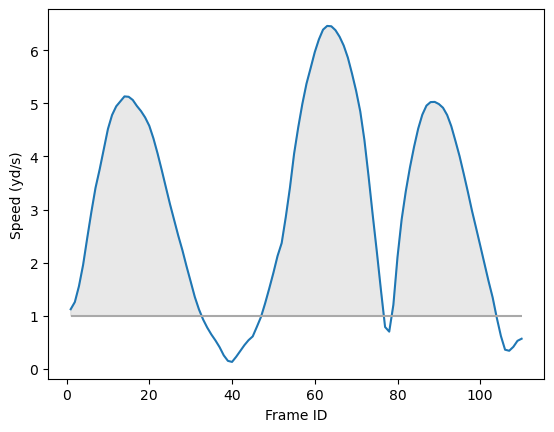

In [264]:
gpid = '2022091102_3943'
NON_STATIONARY_THRESHOLD = 1
MOVING_WINDOW = 3

qry = (
    df_tracking.query(
        'game_play_id==@gpid & ' +\
        'offense & ' +\
        'frame_type.isin(["BEFORE_SNAP","SNAP"]) & ' +\
        'motion_player'
    )
)[['frame_id','s']]

qry['s_smoothed'] = qry['s'].rolling(window=MOVING_WINDOW, min_periods=1, center=True).mean()

plt.plot(qry.frame_id, qry.s_smoothed, zorder=2)
plt.hlines(NON_STATIONARY_THRESHOLD, xmin=qry.frame_id.min(), xmax=qry.frame_id.max(), color='darkgrey')
# shade area above threshold where player is moving
plt.fill_between(
    qry.frame_id,  # x values
    qry.s_smoothed,        # y values
    NON_STATIONARY_THRESHOLD,  # baseline
    where=qry.s_smoothed > NON_STATIONARY_THRESHOLD,  # condition for shading
    interpolate=True,         # interpolates between points
    color='lightgrey',       # shading color
    alpha=0.5,                 # transparency
    zorder=0
)
plt.xlabel('Frame ID')
plt.ylabel('Speed (yd/s)')

# plot_play(df_tracking, gpid, event_col='event_new')

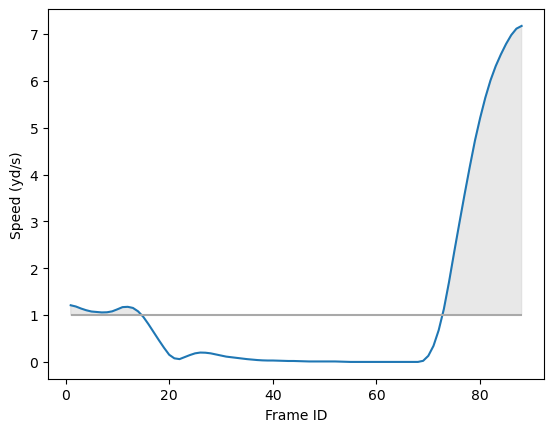

In [37]:
gpid = '2022091112_3627'
NON_STATIONARY_THRESHOLD = 1.0
MOVING_WINDOW = 3

qry = (
    df_tracking.query(
        'game_play_id==@gpid & ' +\
        'offense & ' +\
        'frame_type.isin(["BEFORE_SNAP","SNAP"]) & ' +\
        'motion_player'
    )
)[['frame_id','s']]

qry['s_smoothed'] = qry['s'].rolling(window=MOVING_WINDOW, min_periods=1, center=True).mean()

plt.plot(qry.frame_id, qry.s_smoothed, zorder=2)
plt.hlines(NON_STATIONARY_THRESHOLD, xmin=qry.frame_id.min(), xmax=qry.frame_id.max(), color='darkgrey')
# shade area above threshold where player is moving
plt.fill_between(
    qry.frame_id,  # x values
    qry.s_smoothed,        # y values
    NON_STATIONARY_THRESHOLD,  # baseline
    where=qry.s_smoothed > NON_STATIONARY_THRESHOLD,  # condition for shading
    interpolate=True,         # interpolates between points
    color='lightgrey',       # shading color
    alpha=0.5,                 # transparency
    zorder=0
)
plt.xlabel('Frame ID')
plt.ylabel('Speed (yd/s)')

# highlinght the area in red of last 10 frames

plot_play(df_tracking, gpid, event_col='event_new')

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_play_with_speed(df_tracking, game_play_id, NON_STATIONARY_THRESHOLD=1.0, MOVING_WINDOW=3, every_other_frame=True, event_col='event'):
    qry = 'game_play_id==@game_play_id'
    tracking_play = df_tracking.query(qry).copy().reset_index(drop=True)

    # Keep every other frame, the first and last frames, and frames with events
    first_frame = tracking_play['frame_id'].min()
    last_frame = tracking_play['frame_id'].max()
    frames_with_events = tracking_play.groupby('frame_id')[event_col].transform('any')

    if every_other_frame:
        tracking_play = tracking_play[
            (tracking_play['frame_id'] == first_frame) | 
            (tracking_play['frame_id'] == last_frame) | 
            (frames_with_events) |
            (tracking_play['frame_id'] % 2 == 0)  # Keep even frames only
        ].copy().reset_index(drop=True)

    frames = tracking_play['frame_id'].unique()
    current_event = [None]  

    field_width = 53.3

    # Prepare speed data for the motion player
    motion_query = df_tracking.query(
        'game_play_id==@game_play_id & ' +
        'offense & ' +
        'motion_player'
    )[['frame_id', 's']]
    motion_query['s_smoothed'] = motion_query['s'].rolling(window=MOVING_WINDOW, min_periods=1, center=True).mean()
    min_speed = motion_query['s_smoothed'].min()
    max_speed = motion_query['s_smoothed'].max()
    ball_snap_frame_id = tracking_play.query('event_new == "ball_snap"').frame_id.iloc[0]
    line_set_frame_ids = tracking_play.query('event_new == "line_set"').frame_id.values.tolist()

    # Extract speed and frames
    speed_frames = motion_query['frame_id'].values
    speeds_smoothed = motion_query['s_smoothed'].values

    fig, (ax, ax_speed) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [5, 2]})
    
    padding = 2
    min_y = tracking_play.y.min() - padding
    max_y = tracking_play.y.max() + padding

    los = tracking_play['absolute_yardline_number'].iloc[0]
    to_go_line = los + tracking_play['yards_to_go'].iloc[0]

    def update(frame_id):
        """Update function for each animation frame."""
        ax.clear()
        ax_speed.clear()

        # Field plot
        ax.set_facecolor('lightgrey')
        ax.set_yticks(np.arange(10, 110+1, 5))
        ax.grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='black', zorder=1)

        for spine in ax.spines.values():
            spine.set_visible(False)

        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.set_xlim(0, field_width)
        ax.set_ylim(min_y, max_y)

        current_frame = tracking_play.query('frame_id == @frame_id')
        offense = current_frame.query('offense and ~motion_player')
        defense = current_frame.query('~offense and club != "football"')
        motion_player = current_frame.query('motion_player')
        football = current_frame.query('club == "football"')

        # Plot the line of scrimmage and to-go line
        ax.axhline(los, color='blue', linewidth=1.2, linestyle='-', zorder=1)
        ax.axhline(to_go_line, color='yellow', linewidth=1.2, linestyle='-', zorder=1)

        ax.scatter(offense.x, offense.y, c='#fc8077', edgecolor='black', label='Offense', zorder=2)
        ax.scatter(motion_player.x, motion_player.y, c='red', edgecolor='black', label='Motion Player', zorder=2)
        ax.scatter(defense.x, defense.y, c='blue', edgecolor='black', label='Defense', zorder=2)
        ax.scatter(football.x, football.y, c='brown', edgecolor='black', label='Football', s=20, zorder=3)

        # Event annotation
        event = current_frame[event_col].iloc[0]
        box_color = 'white'  # Default color
        alpha_value = 0.8    # Transparency value
        
        # Set box color based on event type
        if event == 'line_set':
            box_color = 'green'
            alpha_value = 0.5  # More transparency for the green box
        elif event == 'ball_snap':
            box_color = 'red'
            alpha_value = 0.5  # More transparency for the red box
        
        ax.text(
            1, max_y + 1.5, f"{event}",
            fontsize=12, ha='left', color='black',
            bbox=dict(facecolor=box_color, alpha=alpha_value),
            zorder=4
        )

        ax.text(52.3, max_y + 1.5, f"{frame_id / 10:.01f} s", fontsize=12, ha='right', color='black', 
                bbox=dict(facecolor='white', alpha=0.8), zorder=4)

        # Speed plot
        up_to_frame = motion_query[motion_query['frame_id'] <= frame_id]
        ax_speed.plot(
            up_to_frame['frame_id'], 
            up_to_frame['s_smoothed'], 
            zorder=2, 
            color='red'
        )
        ax_speed.hlines(
            NON_STATIONARY_THRESHOLD, 
            xmin=motion_query['frame_id'].min(), 
            xmax=motion_query['frame_id'].max(), 
            color='darkgrey',
            zorder=1
        )
        ax_speed.fill_between(
            up_to_frame['frame_id'],  # x values
            up_to_frame['s_smoothed'],  # y values
            NON_STATIONARY_THRESHOLD,  # baseline
            where=up_to_frame['s_smoothed'] > NON_STATIONARY_THRESHOLD,  # condition for shading
            interpolate=True,         # interpolates between points
            color='lightgrey',       # shading color
            alpha=0.5,               # transparency
            zorder=0
        )

        ax_speed.axvline(ball_snap_frame_id, color='black', linestyle='--', zorder=1)

        for line_set_frame_id in line_set_frame_ids:
            ax_speed.axvline(line_set_frame_id, color='green', linestyle='--', zorder=1, lw=1)

        ax_speed.set_xlabel('Frame ID')
        ax_speed.set_ylabel('Speed (yd/s)')
        ax_speed.set_xlim(motion_query['frame_id'].min(), motion_query['frame_id'].max())
        ax_speed.set_ylim(min_speed-2, max_speed+2)


    ani = FuncAnimation(fig, update, frames=frames, interval=100, repeat=False)

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.95)

    plt.close(fig)

    return HTML(ani.to_jshtml(fps=5))


In [62]:
gpid = '2022091200_64'
plot_play_with_speed(df_tracking, gpid, event_col='event_new')

In [ ]:
# gpid = '2022091100_996'

# WINDOW_WIDTH = 3
# LINE_SET_MEAN_SPEED_THRESHOLD = 0.3
# SPEED_MULTIPLIER_THRESHOLD = 2.0
# SPEED_MULTIPLIER = 3

# play = df_tracking.query('game_play_id == @gpid').copy()
# off_players = play[(play.offense) & (play.frame_type == 'BEFORE_SNAP')].copy()
# off_players['s'] = np.where(
#     off_players['s'] >= SPEED_MULTIPLIER_THRESHOLD, 
#     off_players['s'] * SPEED_MULTIPLIER, 
#     off_players['s']
# )
# off_team = off_players[['frame_id', 's']].groupby('frame_id')['s'].mean().reset_index(drop=True)

# off_team_smoothed = off_team.rolling(window=WINDOW_WIDTH, min_periods=1, center=True).mean()

# event_col = 'event_new'
# play = df_tracking.query('game_play_id==@gpid')
# fids = play[play[event_col] == 'line_set'].frame_id.unique().tolist()

# plt.plot(off_team_smoothed.index, off_team_smoothed)
# plt.hlines(LINE_SET_MEAN_SPEED_THRESHOLD, xmin=1,xmax=off_players.frame_id.max(), color='black')
# plt.fill_between(
#     off_team_smoothed.index,  # x values
#     off_team_smoothed,        # y values
#     LINE_SET_MEAN_SPEED_THRESHOLD,  # baseline
#     where=off_team_smoothed < LINE_SET_MEAN_SPEED_THRESHOLD,  # condition for shading
#     interpolate=True,         # interpolates between points
#     color='lightgrey',       # shading color
#     alpha=0.5                 # transparency
# )
# for fid in fids:
#     plt.axvline(fid, color='green', alpha=0.5)

# plot_play(df_tracking, gpid, event_col=event_col)